In [19]:
import sys
sys.path.append('..')

from genetic_algorithm import GeneticAlgorithm
from signals import Signal
from hyperspaces import close_only_hyperspace
import pandas as pd
import random
from tqdm import tqdm
import vectorbt as vbt
import matplotlib.pyplot as plt


##### Define parameters

In [58]:
asset = 'BTCUSDT'
poplogs_filename = 'test_poplogs.csv'
mutation_rate = 0.2
fitness_option = 'linear_fit_adj_sharpe'
n_trades_threshold_option = 'on'
n_trades_threshold = 100
tournament_size = 3
direction = 'L'
hyperspace = close_only_hyperspace
population_size = 100
num_generations = 1000
close_data_path = '../../binance_futures_close_1d.csv'


##### Initialize GA


In [59]:
# Initialize GA
close = pd.read_csv(close_data_path)
close.set_index('Open time', inplace=True)
close.index = pd.to_datetime(close.index)
close = close[[asset]].loc['2021-01-01':'2024-01-01']

ga = GeneticAlgorithm(
    hyperspace=hyperspace,
    close=close,
    direction=direction,
    asset=asset,
    fitness_option=fitness_option,
    n_trades_threshold_option=n_trades_threshold_option,
    n_trades_threshold=n_trades_threshold
)

# Initialize population
population = [ga.create_limited_individual() for _ in range(population_size)]
fitness_scores = ga.fitness_parametrized(population)
fit = pd.DataFrame({
    'individual': population,
    'fitness_score': fitness_scores
})

##### Run search

In [60]:
# Run GA
poplogs = pd.DataFrame()
for generation in tqdm(range(num_generations)):

    # Selection
    selected = ga.tournament_selection(population, fitness_scores, tournament_size, population_size // 2)

    # Crossover
    offspring = []
    while len(offspring) < population_size - len(selected):
        parent1, parent2 = random.sample(selected, 2)
        children = ga.crossover(parent1, parent2)
        for child in children:
            if child not in population:
                offspring.append(child)
    population = selected + offspring

    # Mutation
    population = [ga.mutate(ind, mutation_rate) for ind in population]

    # Replace duplicates with new unique random individuals
    clean_population = pd.Series(population).drop_duplicates(keep='first').values.tolist()
    num_duplicates = population_size - len(clean_population)
    population = clean_population + [ga.create_limited_individual() for _ in range(num_duplicates)]

    # Evaluate new generation
    fitness_scores = ga.fitness_parametrized(population)
    fit = pd.DataFrame({
        'individual': population,
        'fitness_score': fitness_scores,
        'generation': [generation] * len(population)
    })

    # Update population logs
    poplogs = pd.concat([poplogs, fit])

    # # Get the best performing individual
    # best_individual = poplogs.sort_values('fitness_score', ascending=False).individual.iloc[0]

    # # Run backtest on best individual
    # entry_part, exit_part = best_individual.split('$')
    # entry_part = entry_part.strip()
    # exit_part = exit_part.strip()
    # entry_part = entry_part.replace('(', '(Signal(close).', 1)
    # exit_part = exit_part.replace('(', '(Signal(close).', 1)

    # entries = eval(entry_part)
    # exits = eval(exit_part)

    # if direction == 'L':
    #     pf = vbt.Portfolio.from_signals(close, entries=entries, exits=exits, fees=0.001)
    # elif direction == 'S':
    #     pf = vbt.Portfolio.from_signals(close, short_entries=entries, short_exits=exits, fees=0.001)
    # elif direction == 'LS':
    #     pf = vbt.Portfolio.from_signals(close, entries=entries, short_entries=exits, fees=0.001)

    # # Plot portfolio value
    # fig, ax = plt.subplots(figsize=(10, 3))
    # close.div(close.iloc[0]).mul(100).plot(ax=ax, label='Buy and Hold')
    # pf.value()[].plot(ax=ax, label='Individual')
    # ax.set_title(best_individual)
    # ax.set_xlabel('')
    # ax.legend()
    # plt.show()

    # break

100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s]


##### Evaluate best performing individual


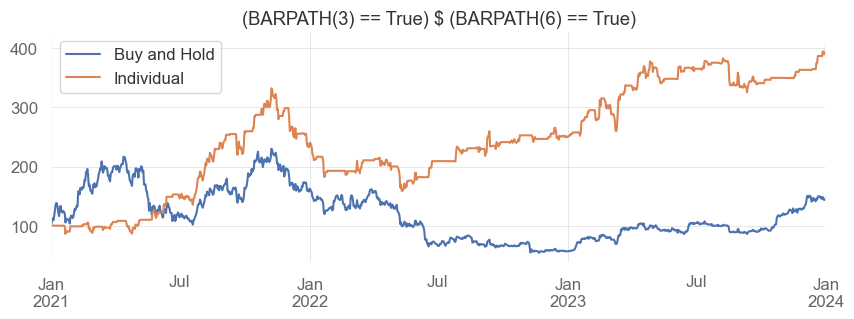

In [61]:
# Get the best performing individual
best_individual = poplogs.sort_values('fitness_score', ascending=False).individual.iloc[0]

# Run backtest on best individual
entry_part, exit_part = best_individual.split('$')
entry_part = entry_part.strip()
exit_part = exit_part.strip()
entry_part = entry_part.replace('(', '(Signal(close).', 1)
exit_part = exit_part.replace('(', '(Signal(close).', 1)

entries = eval(entry_part)
exits = eval(exit_part)

if direction == 'L':
    pf = vbt.Portfolio.from_signals(close, entries=entries, exits=exits, fees=0.001)
elif direction == 'S':
    pf = vbt.Portfolio.from_signals(close, short_entries=entries, short_exits=exits, fees=0.001)
elif direction == 'LS':
    pf = vbt.Portfolio.from_signals(close, entries=entries, short_entries=exits, fees=0.001)

# Plot portfolio value
fig, ax = plt.subplots(figsize=(10, 3))
close.div(close.iloc[0]).mul(100)[asset].plot(ax=ax, label='Buy and Hold')
pf.value()[asset].plot(ax=ax, label='Individual')
ax.set_title(best_individual)
ax.set_xlabel('')
ax.legend()
plt.show()


In [66]:
trades = pf.trades.records_readable
len(trades[trades['Return'] > 0]) / len(trades)


0.7304347826086957